## Импорт библиотек

In [1]:
import pandas as pd
import json
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

## Загрузка данных

In [ ]:
train = pd.read_csv('data/data_allcups/train.csv', sep=';')
test = pd.read_csv('data/data_allcups/test.csv', sep=';')
labels = pd.read_csv('data/data_allcups/train_labels.csv', sep=';')
referer = pd.read_csv('data/data_allcups/referer_vectors.csv', sep=';')
geo = pd.read_csv('data/data_allcups/geo_info.csv', sep=';')

## Подготовка признаков

In [3]:
# Парсинг агента пользователя на браузер и операционную систему 
def parse_user_agent(s: str):
    try:
        s_json = s.replace("'", '"')
        return json.loads(s_json)
    except:
        return {}
    
train['user_agent_dict'] = train['user_agent'].apply(parse_user_agent)
train = pd.concat([train, train['user_agent_dict'].apply(pd.Series)], axis=1)
train = train.drop(columns=['user_agent', 'user_agent_dict', 'browser_version', 'os_version'])

test['user_agent_dict'] = test['user_agent'].apply(parse_user_agent)
test = pd.concat([test, test['user_agent_dict'].apply(pd.Series)], axis=1)
test = test.drop(columns=['user_agent', 'user_agent_dict', 'browser_version', 'os_version'])

In [4]:
# Выделение домена рекламного запроса
referer['domain'] = referer['referer'].apply(lambda ref: ref.replace('https://', '').split('/')[0])

In [5]:
# Выделяем час запроса
train['hour'] = train['request_ts'].apply(lambda ts: datetime.fromtimestamp(ts).hour).astype('str') 
test['hour'] = test['request_ts'].apply(lambda ts: datetime.fromtimestamp(ts).hour).astype('str')

train = train.drop(columns=['request_ts'])
test = test.drop(columns=['request_ts'])

## Проверка пропусков

In [6]:
train.isna().sum()

user_id    0
referer    0
geo_id     0
browser    1
os         1
hour       0
dtype: int64

In [7]:
test.isna().sum().sum()

np.int64(0)

In [8]:
# Заполнение пропусков региона значением страны
geo['region_id'] = geo['region_id'].fillna(geo['country_id'])

In [9]:
# Заполнение пропусков агента нулевым значением
train['browser'] = train['browser'].fillna('none')
train['os'] = train['os'].fillna('none')

### Сбор всех признаков в один датасет

In [10]:
train = train.merge(referer, on='referer', how='left')
train = train.merge(geo, on='geo_id', how='left')
train = train.drop(columns=['geo_id', 'referer'])

test = test.merge(referer, on='referer', how='left')
test = test.merge(geo, on='geo_id', how='left')
test = test.drop(columns=['geo_id', 'referer'])

In [11]:
train.head(5)

,user_id,browser,os,hour,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,domain,country_id,region_id,timezone_id
0,fb858e8e0a2bec074450eaf94b627fd3,Chrome Mobile,Android,18,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,9b48ee5,c31b4e,470e75,f6155e
1,46a5f128fd569c764a92c2eaa788095e,Chrome Mobile,Android,11,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,9b48ee5,c31b4e,44520b,e56e80
2,5a74e9ac53ffb21a20cce117c0ad77ba,Yandex Browser,Android,18,12498,2451,10304,-6380,11608,3106,-2188,10573,3347,21870,9634fd0,c31b4e,616bb9,af47f1
3,af735816ca19115431ae3d89518c8c91,Chrome Mobile,Android,13,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,9b48ee5,c31b4e,3c9dca,e56e80
4,364f0ae0a3f29a685c4fb5bae6033b9a,Yandex Browser,Android,21,11731,4045,22213,-1184,-8992,9381,-3496,-3120,-899,16817,9b48ee5,c31b4e,776e76,10b7947


### Подготовка данных к группировке

In [ ]:
user_agent_cols = ['browser', 'os']
hour_cols = ['hour']
component_cols = [f'component{i}' for i in range(10)]
domain_cols = ['domain']
geo_cols = ['country_id', 'region_id', 'timezone_id']
count_cols = ['count'] # Количество запросов - признак будет добавлен позже

categorical_cols = user_agent_cols + domain_cols + geo_cols + hour_cols

### Группировка признаков по пользователю

In [13]:
# Выделение самого частого значения
def most_frequent(x):
    try:
        return x.mode().iloc[0]
    except:
        return None

# Параметры аггрегации признаков
agg_dict = {
    **{user_agent_col: most_frequent for user_agent_col in user_agent_cols},
    **{hour_col: most_frequent for hour_col in hour_cols},
    **{component: 'mean' for component in component_cols},
    'domain': most_frequent,
    **{geo_col: most_frequent for geo_col in geo_cols},
}

users_train = train.groupby('user_id').agg(agg_dict).reset_index()
users_test = test.groupby('user_id').agg(agg_dict).reset_index()

In [14]:
# Добавление признака количества запросов
train_user_counts = train['user_id'].value_counts().rename('count').reset_index()
train_user_counts.columns = ['user_id', 'count']
users_train = users_train.merge(train_user_counts, on='user_id', how='left')

test_user_counts = test['user_id'].value_counts().rename('count').reset_index()
test_user_counts.columns = ['user_id', 'count']
users_test = users_test.merge(test_user_counts, on='user_id', how='left')

In [ ]:
# Добавление таргета к датасету
users_train = users_train.merge(labels, on='user_id', how='left')
users_test = users_test.merge(labels, on='user_id', how='left')

## Проверка пропущенных значений

In [16]:
users_train.isna().sum()

user_id             0
browser             0
os                  0
hour                0
component0          0
component1          0
component2          0
component3          0
component4          0
component5          0
component6          0
component7          0
component8          0
component9          0
domain              0
country_id          0
region_id           0
timezone_id         0
count               0
target         155672
dtype: int64

In [17]:
# Удаляем объекты без целевого значения
users_train = users_train.dropna(subset='target')

In [18]:
users_train.head(3)

,user_id,browser,os,hour,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,domain,country_id,region_id,timezone_id,count,target
3,00006a10d9ff5f9d312029ac4d296430,YandexSearch,Android,10,10214.0,-1254.0,10495.0,7705.0,9547.0,5801.0,864.0,8837.0,5312.0,22635.0,6a81948,c31b4e,470e75,f6155e,1,1.0
4,00008d5fd6bff19884138510b077a22b,Yandex Browser,iOS,6,10214.0,-1254.0,10495.0,7705.0,9547.0,5801.0,864.0,8837.0,5312.0,22635.0,6a81948,c31b4e,1fbfa5,e56e80,1,1.0
5,000098f8aa8b68a125148caff0a02827,Chrome,Windows,16,15633.0,22503.0,-2155.0,-557.0,2232.0,16084.0,-87.0,-2820.0,6578.0,3085.0,b53adc6,e48e27,e48e27,f0c3df,1,0.0


## Корреляционная матрица вещественных признаков

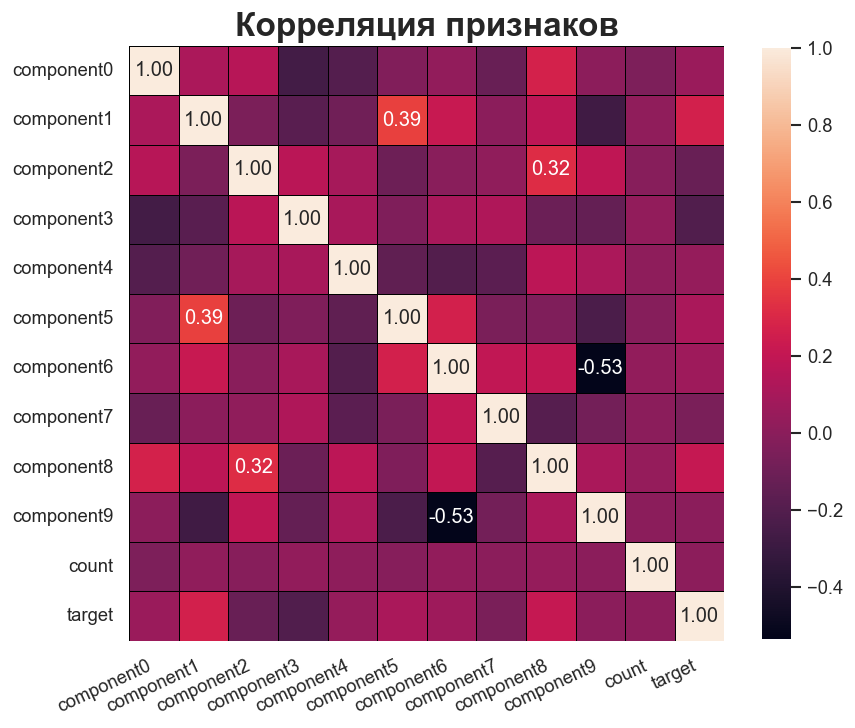

In [ ]:
sns.set_theme(palette="bright")
plt.figure(figsize=(8, 8), dpi=120)

ax = sns.heatmap(
    users_train.corr(numeric_only=True),
    annot=True,
    fmt='0.2f',
    linewidths=0.5,
    linecolor='black',
    cbar_kws={'shrink': 0.8},
    square=True
)

for t in ax.texts:
    if np.abs(float(t.get_text())) < 0.3:
        t.set_text("")

plt.title("Корреляция признаков", fontsize=20, fontweight='bold')
plt.xticks(rotation=25, ha='right')
plt.show()

## Подготовка данных для модели

In [20]:
X = users_train.drop('target', axis=1)
y = users_train['target']

# Разделение выборки на тренировочную, валидационную и тестовую в соотношении 8:1:1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [28]:
# Стандартизация вещественных признаков
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[component_cols + count_cols]), columns=[component_cols + count_cols], index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[component_cols + count_cols]), columns=[component_cols + count_cols], index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[component_cols + count_cols]), columns=[component_cols + count_cols], index=X_test.index)

# Сбор признаков в итоговый датасет для обучения
X_train_final = pd.concat([X_train_scaled, X_train[categorical_cols]], axis=1)
X_val_final = pd.concat([X_val_scaled, X_val[categorical_cols]], axis=1)
X_test_final = pd.concat([X_test_scaled, X_test[categorical_cols]], axis=1)

# Создание Pool для категориальных признаков в CatBoost
train_pool = Pool(X_train_final, label=y_train, cat_features=categorical_cols)
val_pool = Pool(X_val_final, label=y_val, cat_features=categorical_cols)
test_pool = Pool(X_test_final, label=y_test, cat_features=categorical_cols)

# Гиперпараметры модели
model = CatBoostClassifier(
    iterations=1500,
    early_stopping_rounds=15,
    auto_class_weights='Balanced',
    random_seed=42,
    verbose=100
)

## Обучение модели

In [22]:
model.fit(train_pool, eval_set=val_pool)

Learning rate set to 0.116686
0:	learn: 0.6413761	test: 0.6398604	best: 0.6398604 (0)	total: 240ms	remaining: 6m
100:	learn: 0.3794621	test: 0.3680788	best: 0.3680788 (100)	total: 14.5s	remaining: 3m 21s
200:	learn: 0.3581207	test: 0.3469614	best: 0.3469614 (200)	total: 31.7s	remaining: 3m 24s
300:	learn: 0.3483327	test: 0.3382365	best: 0.3382365 (300)	total: 47.7s	remaining: 3m 10s
400:	learn: 0.3414179	test: 0.3324026	best: 0.3324026 (400)	total: 1m 3s	remaining: 2m 54s
500:	learn: 0.3368485	test: 0.3289273	best: 0.3289273 (500)	total: 1m 19s	remaining: 2m 39s
600:	learn: 0.3331941	test: 0.3266013	best: 0.3266013 (600)	total: 1m 36s	remaining: 2m 23s
700:	learn: 0.3300788	test: 0.3246528	best: 0.3246528 (700)	total: 1m 52s	remaining: 2m 8s
800:	learn: 0.3268993	test: 0.3227060	best: 0.3227060 (800)	total: 2m 9s	remaining: 1m 52s
900:	learn: 0.3245531	test: 0.3215585	best: 0.3215585 (900)	total: 2m 28s	remaining: 1m 38s
1000:	learn: 0.3223811	test: 0.3205409	best: 0.3205409 (1000)	tot

## Прогнозирование таргета

In [30]:
y_pred_train = model.predict(train_pool)
y_pred_test = model.predict(test_pool)

## Результат

In [31]:
print("CatBoost")
print(f"Data  | AUC-ROC | Accuracy")
print(f"Train | {roc_auc_score(y_train, y_pred_train):.4f}  | {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test  | {roc_auc_score(y_test, y_pred_test):.4f}  | {accuracy_score(y_test, y_pred_test):.4f}")

CatBoost
Data  | AUC-ROC | Accuracy
Train | 0.9030  | 0.9033
Test  | 0.8760  | 0.8762


## Запись результата в файл

In [27]:
result = pd.DataFrame({
    'user_id': X_test['user_id'],
    'prediction': y_pred_test.astype(int)
})
result.to_csv('data/result.csv', index=False)

## Итог

Data  | AUC-ROC | Accuracy
------|---------|---------
Train | 0.9030  | 0.9033
Test  | 0.8760  | 0.8762